# LA building permits: 2013-2019

In [1]:
import pandas as pd
import requests
import matplotlib as mpl
import geopandas as gpd
import descartes
import geojson
import json
import numpy as np
import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.float_format = '{:,}'.format

### Read data (as of 9/9/2019), clean up column headers

In [2]:
#https://data.lacity.org/A-Prosperous-City/Building-and-Safety-Permit-Information/yv23-pmwf

permits = pd.read_csv('/Users/mhustiles/Desktop/data/LA/Building_and_Safety_Permit_Information.csv', low_memory=False)
permits.columns = permits.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [3]:
permits.columns

Index(['assessor_book', 'assessor_page', 'assessor_parcel', 'tract', 'block',
       'lot', 'reference_#_old_permit_#', 'pcis_permit_#', 'status',
       'status_date', 'permit_type', 'permit_sub-type', 'permit_category',
       'project_number', 'event_code', 'initiating_office', 'issue_date',
       'address_start', 'address_fraction_start', 'address_end',
       'address_fraction_end', 'street_direction', 'street_name',
       'street_suffix', 'suffix_direction', 'unit_range_start',
       'unit_range_end', 'zip_code', 'work_description', 'valuation',
       'floor_area-l.a._zoning_code_definition',
       '#_of_residential_dwelling_units', '#_of_accessory_dwelling_units',
       '#_of_stories', 'contractor's_business_name', 'contractor_address',
       'contractor_city', 'contractor_state', 'license_type', 'license_#',
       'principal_first_name', 'principal_middle_name', 'principal_last_name',
       'license_expiration_date', 'applicant_first_name',
       'applicant_last_name'

### Clean up data types, parse dates

In [4]:
permits['project_number'] = permits['project_number'].astype(str)
permits['address_start'] = permits['address_start'].astype(str)
permits['address_end'] = permits['address_end'].astype(str)
permits['zip_code'] = permits['zip_code'].astype(str).replace('\.0', '', regex=True)
permits['assessor_book'] = permits['assessor_book'].astype(str).replace('\.0', '', regex=True)
permits['assessor_page'] = permits['assessor_page'].astype(str).replace('\.0', '', regex=True)
permits['license_#'] = permits['license_#'].astype(str)
permits['census_tract'] = permits['census_tract'].astype(str)
permits['census_tract'] = '06037' + permits['census_tract'].astype(str)
permits['nu_census_tract'] = permits['census_tract'].str.replace('.','').str.ljust(11, '0')
permits['council_district'] = permits['council_district'].astype(str)
permits['existing_code'] = permits['existing_code'].astype(str)
permits['proposed_code'] = permits['proposed_code'].astype(str)
permits['issue_date'] = pd.to_datetime(permits['issue_date'], format='%m/%d/%Y')
permits['status_date'] = pd.to_datetime(permits['status_date'], format='%m/%d/%Y')
permits['year_issued'] = permits['issue_date'].dt.year.astype(str)
permits['month_issued'] = permits['issue_date'].dt.month.astype(str)
permits['year_issued'] = permits['issue_date'].dt.year.astype(str)
permits['weekday_issued'] = permits['issue_date'].dt.weekday_name.astype(str)
permits['year-status'] = permits['status_date'].dt.year.astype(str)
permits['month-status'] = permits['status_date'].dt.month.astype(str)
permits['year-status'] = permits['status_date'].dt.year.astype(str)
permits['weekday-status'] = permits['status_date'].dt.weekday_name.astype(str)
permits['floor_area-l.a._zoning_code_definition'] = permits['floor_area-l.a._zoning_code_definition'].astype(float)
permits['area'] = permits['floor_area-l.a._zoning_code_definition'].astype(float)
permits['location'] = permits['latitude/longitude']

In [5]:
permits['nu_census_tract']

0          06037102105
1          06037297201
2          06037104703
3          06037139703
4          06037113237
5          06037113212
6          06037186100
7          06037128910
8          06037139702
9          06037135202
10         06037265202
11         06037125600
12         06037265602
13         06037228100
14         06037240300
15         06037127300
16         06037194101
17         06037113301
18         06037120010
19         06037128101
20         06037106112
21         06037211420
22         06037224010
23         06037262704
24         06037205120
25         06037277400
26         06037143901
27         06037113232
28         06037102107
29         06037106520
              ...     
1037198    06037106510
1037199    06037103200
1037200    06037234502
1037201    06037127300
1037202    06037121900
1037203    06037134521
1037204    06037208802
1037205    06037207710
1037206    06037186302
1037207    06037262604
1037208    06037109100
1037209    06037271400
1037210    

### Convert 'location' into separate latitude/longitude fields

In [6]:
permits['location'] = permits.location.str.replace('(', '').str.replace(')', '')

lat = []
lon = []

for row in permits['location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

permits['latitude'] = lat
permits['longitude'] = lon

### How many total permits issued?

In [7]:
len(permits)

1037228

### Recent permits

In [8]:
years = ['2018', '2019']
recent_permits = permits[permits.year_issued.isin(years)]
recent_permits_building = permits[(permits['permit_type'] == 'Bldg-New')]

### How many recent permits for just new single- or dual-family homes

In [48]:
new_home_permits_recent = recent_permits[(permits['permit_type'] == 'Bldg-New') & (permits['permit_sub-type'] == '1 or 2 Family Dwelling')]

/Users/mhustiles/.virtualenvs/jupyter/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [46]:
#how many new home permits is that? 
len(new_home_permits_all)

6672

### Recent permits by census tract

In [11]:
recent_permits.groupby(['nu_census_tract']).census_tract.agg('count').to_frame('count').reset_index()

,nu_census_tract,count
0,06037101110,350
1,06037101122,309
2,06037101210,351
3,06037101220,246
4,06037101300,405
5,06037101400,389
6,06037102102,1
7,06037102103,156
8,06037102104,227
9,06037102105,116


### Filter list of new contruction/homes to specific zip codes

In [12]:
platinum_zips = ['90210', '90077', '90272']
bel_air_zip = ['90077']

# Platinum Triangle
platinum_permits = new_home_permits_all[new_home_permits_all.zip_code.isin(platinum_zips)]
# Just Bel Air
belair_permits = new_home_permits_all[new_home_permits_all.zip_code.isin(bel_air_zip)]
# Everything else
rest_permits = new_home_permits_all[~new_home_permits_all.zip_code.isin(platinum_zips)]

### How do these zip code zones compare?

In [13]:
# Bel Air - by square feet of construction
belair_permits.groupby('zip_code').area.agg(['count', 'mean', 'median', 'max']).round().sort_values(by='median', ascending=False).head(10)

,count,mean,median,max
zip_code,,,,
90077,41,"12,515.0","8,437.0","73,934.0"


In [14]:
#All the Platinum Triangle zips - by square feet of construction
platinum_permits.groupby('zip_code').area.agg(['count', 'mean', 'median', 'max']).round().sort_values(by='median', ascending=False).head(10)

,count,mean,median,max
zip_code,,,,
90077,41,"12,515.0","8,437.0","73,934.0"
90210,16,"11,080.0","5,815.0","55,667.0"
90272,107,"5,412.0","4,812.0","17,266.0"


In [15]:
#Top 10 of everything else in the city - by square feet of construction
rest_permits.groupby('zip_code').area.agg(['count', 'mean', 'median', 'max']).round().sort_values(by='median', ascending=False).head(10)

,count,mean,median,max
zip_code,,,,
90069,35,"7,085.0","6,437.0","21,495.0"
90049,92,"6,718.0","6,040.0","23,030.0"
90067,2,"5,963.0","5,963.0","6,049.0"
91436,65,"5,216.0","4,894.0","13,137.0"
90212,1,"4,621.0","4,621.0","4,621.0"
90094,1,"4,288.0","4,288.0","4,288.0"
90024,24,"4,816.0","4,265.0","9,829.0"
91423,56,"4,146.0","4,245.0","10,248.0"
91356,44,"3,913.0","4,185.0","8,689.0"


### Median area (square feet) of new_home_permits by place

In [16]:
# Platinum Triangle
platinum_permits.area.median()

5499.99

In [17]:
# Bel Air
belair_permits.area.median()

8437.0

In [18]:
# Rest of the city
rest_permits.area.median()

1627.0

### Top 10: new home permits by all zip codes, with count and average, median and max for square feet

In [19]:
new_home_permits_all.groupby('zip_code').area.agg(['size', 'mean', 'median', 'max']).round().sort_values(by='median', ascending=False).head(10)

,size,mean,median,max
zip_code,,,,
90077,41,"12,515.0","8,437.0","73,934.0"
90069,35,"7,085.0","6,437.0","21,495.0"
90049,92,"6,718.0","6,040.0","23,030.0"
90067,2,"5,963.0","5,963.0","6,049.0"
90210,16,"11,080.0","5,815.0","55,667.0"
91436,65,"5,216.0","4,894.0","13,137.0"
90272,108,"5,412.0","4,812.0","17,266.0"
90212,1,"4,621.0","4,621.0","4,621.0"
90094,1,"4,288.0","4,288.0","4,288.0"


### Pivot table with counts by year and zip

In [20]:
belair_permits_agg = belair_permits.agg({'area': ['min', 'max', 'mean', 'median']})
belair_permits_agg.T.round(0)

,min,max,mean,median
area,142.0,"73,934.0","12,515.0","8,437.0"


In [21]:
belair_permits_grouped_area = belair_permits.groupby(['year_issued', 'zip_code']).median()[['area']].round(0).sort_values(by='area', ascending=False).reset_index()

In [22]:
belair_permits_grouped_area.head(10)

,year_issued,zip_code,area
0,2015,90077,"18,998.0"
1,2016,90077,"9,810.0"
2,2013,90077,"8,437.0"
3,2014,90077,"8,436.0"
4,2018,90077,"8,206.0"
5,2017,90077,"7,444.0"
6,2019,90077,"5,701.0"


In [23]:
belair_permits_grouped_area.pivot(index='zip_code', columns='year_issued', values='area').reset_index()

year_issued,zip_code,2013,2014,2015,2016,2017,2018,2019
0,90077,"8,437.0","8,436.0","18,998.0","9,810.0","7,444.0","8,206.0","5,701.0"


In [24]:
platinum_permits.groupby(['year_issued', 'zip_code']).median()[['area']].round(0).sort_values(by='area', ascending=False)

area
year_issued zip_code         
2018        90210    28,028.0
2015        90077    18,998.0
2016        90077     9,810.0
2013        90077     8,437.0
2014        90077     8,436.0
2016        90210     8,351.0
2018        90077     8,206.0
2017        90077     7,444.0
            90210     6,277.0
2019        90077     5,701.0
2018        90272     5,651.0
2015        90210     5,502.0
2013        90210     5,294.0
2017        90272     5,198.0
2015        90272     5,039.0
2014        90272     4,826.0
2016        90272     4,348.0
2019        90210     4,333.0
            90272     4,296.0
2013        90272     3,566.0

In [25]:
belair_permits[['year_issued', 'address_start', 'street_name', 'area']].sort_values(by='area', ascending=False)

,year_issued,address_start,street_name,area
690283,2014,944.0,AIROLE,"73,934.0"
367841,2016,800.0,TORTUOSO,"56,797.0"
600220,2015,800.0,STRADELLA,"25,832.0"
147975,2016,642.0,SAINT CLOUD,"21,669.0"
847239,2015,454.0,CUESTA,"21,058.0"
343720,2015,10701.0,BELLAGIO,"20,196.0"
81261,2016,805.0,NIMES,"18,584.0"
749551,2015,1516.0,STONE CANYON,"17,800.0"
439601,2014,10460.0,REVUELTA,"17,481.0"
965488,2017,10830.0,CHALON,"16,536.0"


### Lookup one permit record

In [26]:
belair_permits.loc[485304]

assessor_book                                                                           4370
assessor_page                                                                            021
assessor_parcel                                                                          020
tract                                                                                BEL-AIR
block                                                                                    NaN
lot                                                                                     LT L
reference_#_old_permit_#                                                           19WL98595
pcis_permit_#                                                              18010-30000-03707
status                                                                                Issued
status_date                                                              2019-05-01 00:00:00
permit_type                                                           

### Recent new building homes permits by tract

In [50]:
recent_home_permits_cnt_tract = new_home_permits_recent.groupby(['nu_census_tract']).nu_census_tract.agg('count').to_frame('count').reset_index()

### Recent permits by tract

In [51]:
recent_permits_cnt_tract = recent_permits.groupby(['nu_census_tract']).nu_census_tract.agg('count').to_frame('count').reset_index()

In [52]:
recent_permits_cnt_tract.tail()

,nu_census_tract,count
1103,06037980024,69
1104,06037980026,8
1105,06037980028,2812
1106,06037980031,222
1107,06037nan000,156


## Geography

### LA County census tracts

In [53]:
la_cty_tract = gpd.read_file('/Users/mhustiles/Desktop/github/notebooks/permits/input/tracts.geojson')

In [54]:
la_cty_tract.columns = la_cty_tract.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

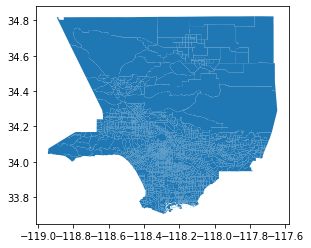

In [55]:
la_cty_tract.plot()

In [56]:
la_cty_tract['geoid10']

0       06037911001
1       06037980003
2       06037930301
3       06037573003
4       06037297602
5       06037297601
6       06037577504
7       06037576903
8       06037576302
9       06037576301
10      06037576001
11      06037293306
12      06037295103
13      06037980015
14      06037670602
15      06037670416
16      06037670328
17      06037670326
18      06037670324
19      06037651402
20      06037651401
21      06037297202
22      06037297201
23      06037296902
24      06037296901
25      06037296402
26      06037296401
27      06037294701
28      06037294421
29      06037294302
           ...     
2312    06037404301
2313    06037406102
2314    06037401002
2315    06037400800
2316    06037910001
2317    06037403702
2318    06037403408
2319    06037408626
2320    06037401001
2321    06037401102
2322    06037401101
2323    06037401500
2324    06037401203
2325    06037401201
2326    06037403902
2327    06037404100
2328    06037400206
2329    06037400302
2330    06037408706


In [60]:
merged_recent = la_cty_tract.merge(recent_permits_cnt_tract, left_on='geoid10', right_on='nu_census_tract')
merged_recent_home = la_cty_tract.merge(recent_home_permits_cnt_tract, left_on='geoid10', right_on='nu_census_tract')

In [61]:
merged_recent.to_file('/Users/mhustiles/Desktop/github/notebooks/permits/output/merged_recent.geojson', driver='GeoJSON')

In [62]:
merged_recent_home.to_file('/Users/mhustiles/Desktop/github/notebooks/permits/output/merged_recent_home.geojson', driver='GeoJSON')

In [59]:
recent_permits['census_tract']

0          060371021.05
1          060372972.01
3          060371397.03
6           060371861.0
9          060371352.02
10         060372652.02
11          060371256.0
12         060372656.02
13          060372281.0
14          060372403.0
20         060371061.12
21          060372114.2
22          060372240.1
25          060372774.0
28         060371021.07
30          060372347.0
31         060371031.01
34         060371133.03
36         060371082.02
39         060372345.01
40         060372933.06
42          060371956.0
43         060371371.03
44          060372079.0
45          060371994.0
48         060371221.22
49          060372770.0
54          060371043.1
55         060372623.03
58          060371901.0
               ...     
1037099    060372073.01
1037108    060371132.31
1037114    060371173.03
1037118     060372651.0
1037121     060372285.0
1037122     060371957.2
1037124    060372611.01
1037126    060371081.02
1037133     060372693.0
1037134    060371899.02
1037139    06037